<a href="https://colab.research.google.com/github/rish4/Minor-Project/blob/main/ResNet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install resnet

  Created wheel for resnet: filename=resnet-0.1-py3-none-any.whl size=10041 sha256=6e27d6af97bc2e34a2fe707969b41f333963c5d3d8f2de298868f67115013d1d
  Stored in directory: /root/.cache/pip/wheels/38/23/58/6e83e34ced7d4772b88e2e86305f94a1ca497bd87937f5e7ec
Successfully built resnet


In [2]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 10
batch_size = 32

In [4]:
# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = '/content/drive/MyDrive/Cats and Dogs Dataset/training_set'
valid_path = '/content/drive/MyDrive/Cats and Dogs Dataset/test_set'

In [5]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')


In [6]:
# useful for getting number of classes
folders = glob(train_path + '/*')

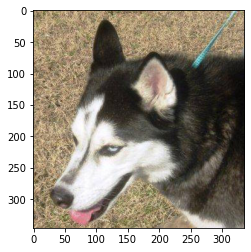

In [7]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [8]:
# add preprocessing layer to the front of VGG
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [9]:
# don't train existing weights
for layer in res.layers:
  layer.trainable = False

In [10]:
# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=res.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [15]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -95.47332 max: 151.061


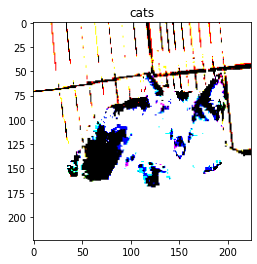

In [16]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [17]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [18]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
250/250 [==============================] - 2108s 8s/step - loss: 2.1231 - accuracy: 0.9197 - val_loss: 2.3659 - val_accuracy: 0.9340
Epoch 2/10
250/250 [==============================] - 1651s 7s/step - loss: 1.9816 - accuracy: 0.9423 - val_loss: 2.9101 - val_accuracy: 0.9264
Epoch 3/10
250/250 [==============================] - 1666s 7s/step - loss: 2.0061 - accuracy: 0.9504 - val_loss: 2.2155 - val_accuracy: 0.9476
Epoch 4/10
250/250 [==============================] - 1701s 7s/step - loss: 2.1854 - accuracy: 0.9494 - val_loss: 2.8549 - val_accuracy: 0.9410
Epoch 5/10
250/250 [==============================] - 1686s 7s/step - loss: 2.4353 - accuracy: 0.9546 - val_loss: 3.3066 - val_accuracy: 0.9476
Epoch 6/10
250/250 [==============================] - 1688s 7s/step - loss: 1.8672 - accuracy: 0.9597 - val_loss: 3.6621 - val_accuracy: 0.9360
Epoch 7/10
250/250 [==============================] - 1694s 7s/step - loss: 1.9478 - accuracy: 0.9605 - val_loss: 2.7121 - val_accuracy:

In [19]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  import seaborn as sns
  f = sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

  TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
  accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
  precision = TP / (TP+FP) # % positive out of all predicted positives
  recall =  TP / (TP+FN) # % positive out of all supposed to be positives
  specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
  f1 = 2*precision*recall / (precision + recall)
  stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
  print(stats_summary)

  return cm

Generating confusion matrix 8000
Found 8000 images belonging to 2 classes.
50
100
[Summary Statistics]
Accuracy = 96.94% | Precision = 96.46% | Recall = 97.45% | Specificity = 96.43% | F1 Score = 96.95%
[[3857  143]
 [ 102 3898]]


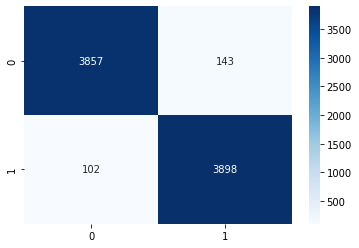

In [20]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)


Generating confusion matrix 2000
Found 2000 images belonging to 2 classes.
[Summary Statistics]
Accuracy = 95.00% | Precision = 94.20% | Recall = 95.90% | Specificity = 94.10% | F1 Score = 95.04%
[[941  59]
 [ 41 959]]


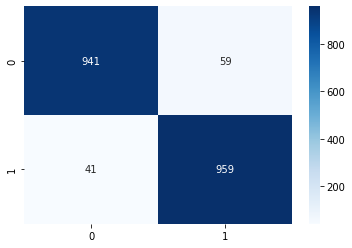

In [23]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

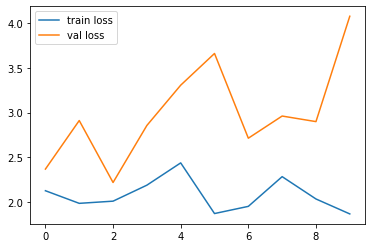

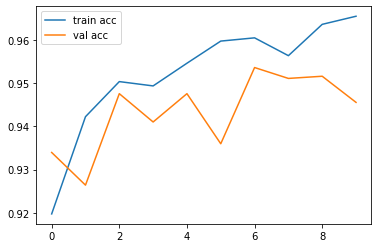

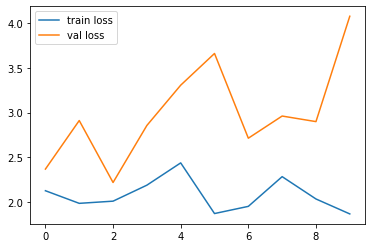

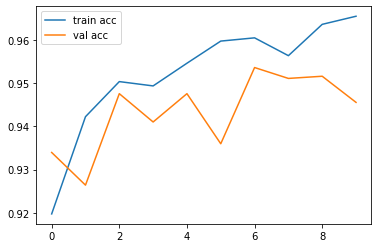

In [22]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


